# **First Neural Network in PyTorch** - Iris Data

## **0.** Settings

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import datasets
import torch.nn as nn
import pandas as pd
import torch

## **1.** Dataset

In [3]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'])
y = iris.target

If we had imported the original dataset, `iris` would have had a `Name` column with the names of the three species.<br>
In that case, to transform from species to label we could have used:

In [ ]:
# mappings = {
#    'Iris-setosa':     0,
#    'Iris-versicolor': 1,
#    'Iris-virginica':  2
# }

# iris['Name'] = iris['Name'].apply(lambda x: mappings[x])

## **2.** Train/Validation

In [4]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since `PyTorch` works with tensors, we need to transform everything from numpy arrays to pytorch tensors.

In [5]:
# From the dataframe we need to extract only values: type(X_train.values) = numpy.ndarray
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)

# The target was already in a good format: numpy.ndarray
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [6]:
# Type of the output
y_train

tensor([0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0,
        2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1,
        0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0,
        0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
        2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

## **3.** Model definition

`PyTorch` uses an object-orientated way of declaring models.<br>
In the constructor we define all the layers and their architecture, while in the `forward()` method we define a forward pass.

The structure of the network that we want to implement will be very simple:
* fully connected layer (4 input features (number of features in `X`), 16 output features (arbitrary))
* fully connected layer (16 input features (number of output features from the previous layer), 12 output features (arbitrary))
* output layer (12 input features (number of output features from the previous layer), 3 output features (number of distinct classes))

Moreover, we’ll use `ReLU()` as activation function.

In [13]:
class ANN(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=3)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [14]:
model = ANN()
model

ANN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=3, bias=True)
)

## **4.** Compile and train

Define:
* criterion - how to measure loss (`CrossEntropyLoss()`)
* optimizer - optimization algorithm (`Adam()` with a learning rate of 0.01)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

We’ll train the model for 200 epochs, keeping track of loss.<br>
Every 10 epochs we’ll output the current status, indicating on which epoch we are and what is the current loss.

In [16]:
epochs = 200
loss_arr = []

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 1.2032405138015747
Epoch: 10 Loss: 1.0274580717086792
Epoch: 20 Loss: 0.9247804284095764
Epoch: 30 Loss: 0.7262775897979736
Epoch: 40 Loss: 0.49105897545814514
Epoch: 50 Loss: 0.3468307852745056
Epoch: 60 Loss: 0.182622030377388
Epoch: 70 Loss: 0.10144554823637009
Epoch: 80 Loss: 0.07508597522974014
Epoch: 90 Loss: 0.06567076593637466
Epoch: 100 Loss: 0.06160327047109604
Epoch: 110 Loss: 0.05957133322954178
Epoch: 120 Loss: 0.05830174311995506
Epoch: 130 Loss: 0.05738382413983345
Epoch: 140 Loss: 0.056645847856998444
Epoch: 150 Loss: 0.05601460486650467
Epoch: 160 Loss: 0.055451877415180206
Epoch: 170 Loss: 0.05493714287877083
Epoch: 180 Loss: 0.05445869266986847
Epoch: 190 Loss: 0.05400870367884636


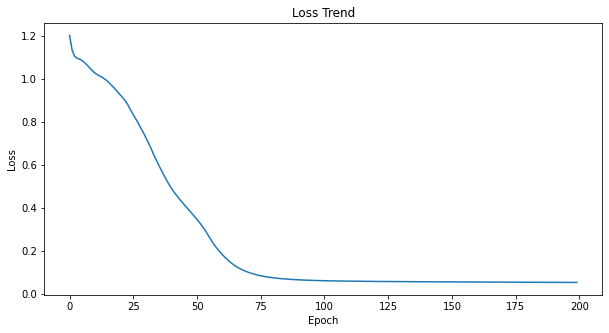

In [17]:
# Trend of the loss function
loss_list = []

for i in range(len(loss_arr)):
    loss_list.append(float(loss_arr[i].detach()))

plt.figure(figsize=(10,5))
plt.plot(loss_list);
plt.title('Loss Trend');
plt.xlabel('Epoch');
plt.ylabel('Loss');

## **5.** Evaluation

We need to iterate over `X_test` and make a prediction.<br>
Later we'll compare it to the actual value.

We will use `torch.no_grad()` here because we’re just evaluating, there’s no need to update weights and biases.

In [18]:
preds = []

with torch.no_grad():
   for val in X_test:
       y_hat = model.forward(val)
       preds.append(y_hat.argmax().item())

The predictions are stored in `preds` array.<br>
We can now make a `DataFrame` in `Pandas` with the following three attributes:
* `Y` - actual value
* `Y_hat` - predicted value
* `Correct` - flag, 1 indicating `Y` and `Y_hat` match, 0 otherwise


In [22]:
df = pd.DataFrame({'Y': y_test, 'Y_hat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['Y_hat'])]
df.head()

,Y,Y_hat,Correct
0,1,1,1
1,0,0,1
2,2,2,1
3,1,1,1
4,1,1,1


In [23]:
print('Percentage of correct predictions:', 100*df['Correct'].sum()/len(df), '%')

Percentage of correct predictions: 100.0 %


The accuracy of the model on previously unseen data is 100%.<br>
This is only because the Iris dataset is very simple to classify.